In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from numpy.random import normal, poisson

from graspologic.simulations import sbm
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.embed import AdjacencySpectralEmbed as ASE
from graspologic.plot import heatmap, pairplot
from graspologic.utils import remove_vertices

from scipy.linalg import orthogonal_procrustes
from scipy.spatial import procrustes

from sklearn.decomposition import TruncatedSVD
from scipy.stats import norm
from scipy.stats import rankdata

np.random.seed(1)

# Tutorial

A.shape= (399, 399) a.shape= (1, 399)


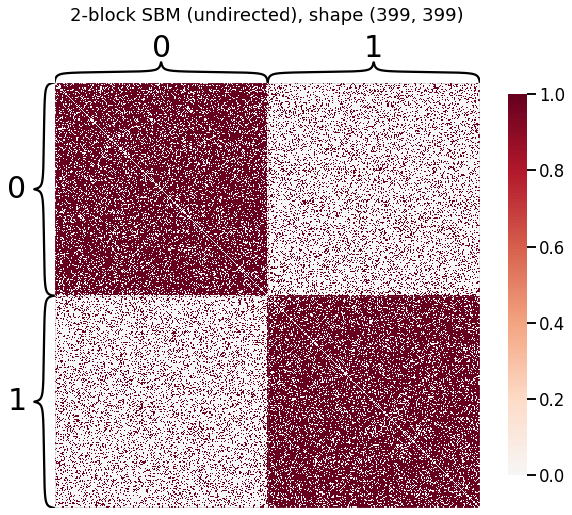

In [2]:
# Generate parameters
nodes_per_community = 200
P = np.array([[0.8, 0.2],
              [0.2, 0.8]])
latents = np.repeat(P, nodes_per_community, axis=0)

# Generate an undirected Stochastic Block Model (SBM)
undirected, labels_ = sbm(2*[nodes_per_community], P, return_labels=True)
labels = list(labels_)

# Grab out-of-sample vertices
oos_idx = 399
oos_labels = labels.pop(oos_idx)
A, a = remove_vertices(undirected, indices=[oos_idx], return_removed=True)
print("A.shape=", A.shape, "a.shape=", a.shape)
# plot our SBM
heatmap(A, title=f'2-block SBM (undirected), shape {A.shape}', inner_hier_labels=labels);

In [5]:
lse = LSE(n_components=2)
X_hat = lse.fit_transform(A)
print("first rown in X_hat = ", X_hat[200])
# predicted latent positions
w = lse.transform(a)
print("OOS embedding = ", w)

first rown in X_hat =  [ 0.0504554  -0.03756232]
OOS embedding =  [[ 0.05290558 -0.04007724]]


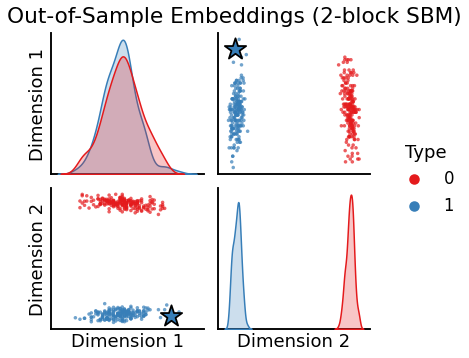

In [6]:
def plot_oos(X_hat, oos_vertices, labels, oos_labels, title):
    # Plot the in-sample latent positions
    plot = pairplot(X_hat, labels=labels, title=title)

    # generate an out-of-sample dataframe
    oos_vertices = np.atleast_2d(oos_vertices)
    data = {'Type': oos_labels,
          'Dimension 1': oos_vertices[:, 0],
          'Dimension 2': oos_vertices[:, 1]}
    oos_df = pd.DataFrame(data=data)

    # update plot with out-of-sample latent positions,
    # plotting out-of-sample latent positions as stars
    plot.data = oos_df
    plot.hue_vals = oos_df["Type"]
    plot.map_offdiag(sns.scatterplot, s=500,
                     marker="*", edgecolor="black")
    plot.tight_layout()
    return plot

# Plot all latent positions
plot_oos(X_hat, w, labels=labels, oos_labels=oos_labels, title="Out-of-Sample Embeddings (2-block SBM)");

# Demonstrate code given to me works

In [7]:
def _profile_likelihood_maximization(U, n_elbows):
    """
    Inputs
        U - An ordered or unordered list of eigenvalues
        n - The number of elbows to return
    Return
        elbows - A numpy array containing elbows
    """
    if type(U) == list:  # cast to array for functionality later
        U = np.array(U)

    if n_elbows == 0:  # nothing to do..
        return np.array([])

    if U.ndim == 2:
        U = np.std(U, axis=0)

    if len(U) == 0:
        return np.array([])

    elbows = []

    if len(U) == 1:
        return np.array(elbows.append(U[0]))

    # select values greater than the threshold
    U.sort()  # sort
    U = U[::-1]  # reverse array so that it is sorted in descending order
    n = len(U)

    while len(elbows) < n_elbows and len(U) > 1:
        d = 1
        sample_var = np.var(U, ddof=1)
        sample_scale = sample_var ** (1 / 2)
        elbow = 0
        likelihood_elbow = -1000000
        while d < len(U):
            mean_sig = np.mean(U[:d])
            mean_noise = np.mean(U[d:])
            sig_likelihood = 0
            noise_likelihood = 0
            for i in range(d):
                sig_likelihood += np.log(norm.pdf(U[i], mean_sig, sample_scale))
            for i in range(d, len(U)):
                noise_likelihood += np.log(norm.pdf(U[i], mean_noise, sample_scale))

            likelihood = noise_likelihood + sig_likelihood

            if likelihood > likelihood_elbow:
                likelihood_elbow = likelihood
                elbow = d
            d += 1
        if len(elbows) == 0:
            elbows.append(elbow)
        else:
            elbows.append(elbow + elbows[-1])
        U = U[elbow:]

    if len(elbows) == n_elbows:
        return np.array(elbows)

    if len(U) == 0:
        return np.array(elbows)
    else:
        elbows.append(n)
        return np.array(elbows)
    
def produce(inpt, out_samp, max_dimension = 1, which_elbow = 1, n_in_sample = 1000):
    """
    Perform Out of Sample Laplacian Spectral Embedding on a graph.
    max_dimension >= 1
    which_elbow is 1 or 2
    n_in_sample >= 1
    
    """
    g = inpt.copy()

    n = g.shape[0]
    D = np.linalg.pinv(np.diag(g.sum(axis=1))**(1/2))
    L = D @ g @ D

    if max_dimension >= n:
        max_dimension = n - 1
    d_max = max_dimension

    in_sample_n = n_in_sample

    if in_sample_n > n:
        in_sample_n = n
    #print("n = ", n)
#     in_sample_idx = np.random.choice(n, in_sample_n)
    if len(out_samp)!=0:
        in_sample_idx = np.setdiff1d(np.arange(n), out_samp)
        #print("in_sample_idx = ", in_sample_idx)
    #     out_sample_idx = np.setdiff1d(list(range(n)),in_sample_idx)
        out_sample_idx = out_samp
        #print("out_sample_idx = ", out_sample_idx)

        in_sample_A = L[np.ix_(in_sample_idx, in_sample_idx)]
        #print("in_sample_A shape = ", in_sample_A.shape)
        out_sample_A = L[np.ix_(out_sample_idx, in_sample_idx)]
    else:
        in_sample_idx=np.arange(n)
        in_sample_A = L
        out_sample_idx = np.array([])
    #print("out_sample_A shape = ", out_sample_A.shape)

    tsvd = TruncatedSVD(n_components = d_max)
    tsvd.fit(in_sample_A)

    eig_vectors = tsvd.components_.T
    eig_values = tsvd.singular_values_
    elbow = _profile_likelihood_maximization(eig_values, which_elbow)[-1]

    eig_vectors = eig_vectors[:, :elbow + 1].copy()
    eig_values = eig_values[:elbow + 1].copy()
    d = len(eig_values)

    in_sample_embedding = eig_vectors.dot(np.diag(eig_values**0.5))
    
    embedding = np.zeros((n,d))
    
    if len(out_samp)!=0:  
        out_sample_embedding = out_sample_A @ eig_vectors @ np.diag(1/np.sqrt(eig_values))
        embedding[out_sample_idx] = out_sample_embedding
    
    embedding[in_sample_idx] = in_sample_embedding
        

    return embedding, in_sample_idx, out_sample_idx

In [6]:
first_comm = True
n_iters = 10

comm_label = []
oos_embed = []

for n_nodes in [50, 100, 500]:
    comm_label.append([])
    oos_embed.append([])
    
    # Generate parameters
    P = np.array([[0.8, 0.2],
                  [0.2, 0.8]])
    latents = np.repeat(P, n_nodes, axis=0)

    # Generate an undirected Stochastic Block Model (SBM)
    undirected, labels_ = sbm(2*[n_nodes], P, return_labels=True)
    labels = list(labels_)
    
    for ii in range(n_iters):
        # Grab out-of-sample vertices
        if first_comm:
            oos_idx = np.random.choice(np.arange(n_nodes))
        else:
            oos_idx = np.random.choice(np.arange(n_nodes, n_nodes*2))
     
        #run alg
        embding, insmpl, outsmpl = produce(undirected, np.array([oos_idx]), max_dimension=2, n_in_sample=1000)

        print("correct embedding = ", embding[0 if first_comm else n_nodes], ", OOS embedding = ", embding[outsmpl])

        # save to lists
        comm_label[-1].append(labels[oos_idx])
        oos_embed[-1].append(embding[outsmpl][0])

        # change community
        first_comm = not first_comm

correct embedding =  [ 0.07444385 -0.09494349] , OOS embedding =  [[ 0.12931342 -0.07452374]]
correct embedding =  [0.07241817 0.1096801 ] , OOS embedding =  [[0.13063676 0.04946259]]
correct embedding =  [ 0.07481457 -0.09365786] , OOS embedding =  [[ 0.12789237 -0.05635221]]
correct embedding =  [0.07033226 0.10798761] , OOS embedding =  [[0.12784378 0.07085811]]
correct embedding =  [ 0.07435443 -0.09509254] , OOS embedding =  [[ 0.13064901 -0.07742209]]
correct embedding =  [0.07252193 0.10924294] , OOS embedding =  [[0.1292506  0.04466437]]
correct embedding =  [ 0.07477165 -0.09480705] , OOS embedding =  [[ 0.13334404 -0.06529447]]
correct embedding =  [0.07056079 0.10743858] , OOS embedding =  [[0.13458475 0.06160913]]
correct embedding =  [0.07503578 0.09416052] , OOS embedding =  [[0.14102079 0.05470099]]
correct embedding =  [0.07252193 0.10924294] , OOS embedding =  [[0.1292506  0.04466437]]
correct embedding =  [0.05436856 0.07894071] , OOS embedding =  [[0.08729976 0.04604

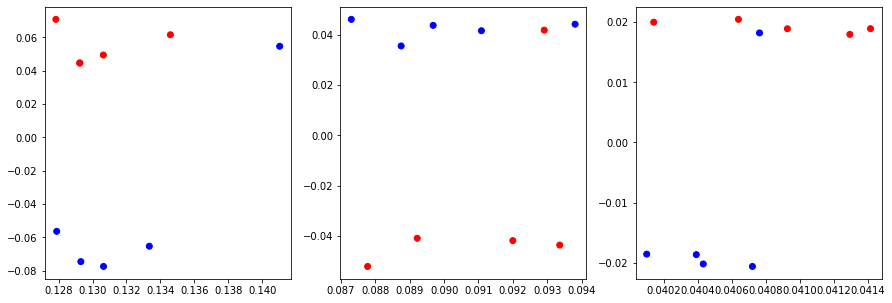

In [8]:
plt.figure(figsize = (15, 5))
for ii in range(3):
    cols = ['red' if xx == 1 else 'blue' for xx in comm_label[ii]]
    plt.subplot(1, 3, ii+1)
    cur_arr = np.array(oos_embed[ii])
    plt.scatter(cur_arr[:, 0], cur_arr[:, 1], c=cols)

# Proof it works
Recreating figure 1 in [paper](https://arxiv.org/pdf/1802.06307.pdf) from Levin
![](figure_to_reproduce.png)

In [28]:
first_comm = True
n_iters = 100

comm_label = []
oos_embed = []

for n_nodes in [50, 100, 500]:
    comm_label.append([])
    oos_embed.append([])
    
    # Generate parameters
    P = np.array([[0.7, 0.3],
                  [0.3, 0.7]])
    latents = np.repeat(P, n_nodes, axis=0)

    # Generate an undirected Stochastic Block Model (SBM)
    undirected, labels_ = sbm(2*[n_nodes], P, return_labels=True)
    labels = list(labels_)
    
    for ii in range(n_iters):
        # Grab out-of-sample vertices
        if first_comm:
            oos_idx = np.random.choice(np.arange(n_nodes))
        else:
            oos_idx = np.random.choice(np.arange(n_nodes, n_nodes*2))
        
        is_idx = np.setdiff1d(np.arange(n_nodes*2), oos_idx)
            
        A, a = remove_vertices(undirected, indices=[oos_idx], return_removed=True)

        lse = LSE(n_components=2)
        X_hat = lse.fit_transform(A)
        
        #start the procrustes alignment
        X = X_hat
        Y = latents[is_idx]
        
        X_bar = np.mean(X, 0); Y_bar = np.mean(Y, 0)
        
        X-=X_bar; Y-=Y_bar
        
        X_norm = np.linalg.norm(X); Y_norm = np.linalg.norm(Y)
        
        X/=X_norm; Y/=Y_norm
        
        R, sca = orthogonal_procrustes(Y, X)

        # predicted latent positions
        w = lse.transform(a)
        w-=X_bar; w/=X_norm
        
        w_rot = np.dot(w, R.T)*sca
        w_rot*=Y_norm; w_rot+=Y_bar

        print("correct embedding = ", np.dot(X_hat[0 if first_comm else n_nodes], R) * sca, 
              ", OOS embedding = ", w_rot)

        # save to lists
        comm_label[-1].append(labels[oos_idx])
        oos_embed[-1].append(w_rot[0])

        # change community
        first_comm = not first_comm

correct embedding =  [-0.09154303 -0.08823015] , OOS embedding =  [[0.68525323 0.31938324]]
correct embedding =  [0.04005425 0.04758288] , OOS embedding =  [[0.41182524 0.6419122 ]]
correct embedding =  [ 0.09439461 -0.08787251] , OOS embedding =  [[0.67255644 0.37015602]]
correct embedding =  [-0.04183246  0.04970697] , OOS embedding =  [[0.22207542 0.67612131]]
correct embedding =  [ 0.09186368 -0.08782436] , OOS embedding =  [[0.65025402 0.30653309]]
correct embedding =  [0.03952314 0.0449926 ] , OOS embedding =  [[0.36440715 0.67597048]]
correct embedding =  [-0.09154303 -0.08823015] , OOS embedding =  [[0.68525323 0.31938324]]
correct embedding =  [-0.04099308  0.04927008] , OOS embedding =  [[0.27962311 0.7048225 ]]
correct embedding =  [-0.0917595  -0.08843297] , OOS embedding =  [[0.70107791 0.3005712 ]]
correct embedding =  [-0.03922903  0.04577706] , OOS embedding =  [[0.36880769 0.71041903]]
correct embedding =  [ 0.0964129 -0.0898622] , OOS embedding =  [[0.72737453 0.27912

correct embedding =  [0.03949872 0.04544152] , OOS embedding =  [[0.28812263 0.5731193 ]]
correct embedding =  [ 0.09192284 -0.08745323] , OOS embedding =  [[0.69847469 0.3312796 ]]
correct embedding =  [-0.03838931  0.04425503] , OOS embedding =  [[0.26842208 0.66036061]]
correct embedding =  [-0.09139741 -0.08821204] , OOS embedding =  [[0.73605537 0.3402571 ]]
correct embedding =  [0.04055676 0.04617093] , OOS embedding =  [[0.16026221 0.76053812]]
correct embedding =  [-0.05910894 -0.05101887] , OOS embedding =  [[0.66939216 0.34080173]]
correct embedding =  [-0.04853064  0.04162319] , OOS embedding =  [[0.33759993 0.69048253]]
correct embedding =  [-0.05970294 -0.05241135] , OOS embedding =  [[0.69424175 0.3272861 ]]
correct embedding =  [-0.04860311  0.04162638] , OOS embedding =  [[0.33832079 0.6385407 ]]
correct embedding =  [ 0.05910325 -0.0510976 ] , OOS embedding =  [[0.68916566 0.34878828]]
correct embedding =  [-0.04847468  0.04153769] , OOS embedding =  [[0.31886606 0.704

correct embedding =  [0.04828495 0.0416948 ] , OOS embedding =  [[0.35690809 0.69968547]]
correct embedding =  [-0.05970426 -0.05240234] , OOS embedding =  [[0.69870248 0.31825903]]
correct embedding =  [-0.04861771  0.04168534] , OOS embedding =  [[0.33340023 0.68123777]]
correct embedding =  [ 0.05974181 -0.05272099] , OOS embedding =  [[0.70308629 0.26987567]]
correct embedding =  [0.04948959 0.04219065] , OOS embedding =  [[0.3314794  0.67131298]]
correct embedding =  [-0.05928289 -0.05113553] , OOS embedding =  [[0.6884655 0.2893829]]
correct embedding =  [0.04842455 0.04191463] , OOS embedding =  [[0.27184466 0.71423955]]
correct embedding =  [ 0.05964474 -0.05248328] , OOS embedding =  [[0.69709985 0.32770058]]
correct embedding =  [-0.04878241  0.04182156] , OOS embedding =  [[0.30825471 0.69912127]]
correct embedding =  [-0.05917628 -0.05106013] , OOS embedding =  [[0.65643604 0.31532332]]
correct embedding =  [-0.04847166  0.04164682] , OOS embedding =  [[0.37688466 0.6786034

correct embedding =  [-0.02024951  0.02223498] , OOS embedding =  [[0.26303093 0.70631985]]
correct embedding =  [ 0.02331329 -0.02345249] , OOS embedding =  [[0.70920656 0.32035941]]
correct embedding =  [0.0202232  0.02206785] , OOS embedding =  [[0.24978484 0.71999983]]
correct embedding =  [ 0.02330757 -0.02344974] , OOS embedding =  [[0.69661424 0.31758942]]
correct embedding =  [-0.02017511  0.02209646] , OOS embedding =  [[0.31984571 0.69438383]]
correct embedding =  [ 0.02330806 -0.02345047] , OOS embedding =  [[0.71204035 0.29236903]]
correct embedding =  [0.02020899 0.02205341] , OOS embedding =  [[0.29947867 0.70589544]]
correct embedding =  [-0.02332009 -0.02344017] , OOS embedding =  [[0.6958677  0.29241325]]
correct embedding =  [0.02021246 0.02205695] , OOS embedding =  [[0.30640577 0.70195309]]
correct embedding =  [-0.02332684 -0.02344856] , OOS embedding =  [[0.71282605 0.28955874]]
correct embedding =  [0.02020539 0.02205307] , OOS embedding =  [[0.29943547 0.667828 

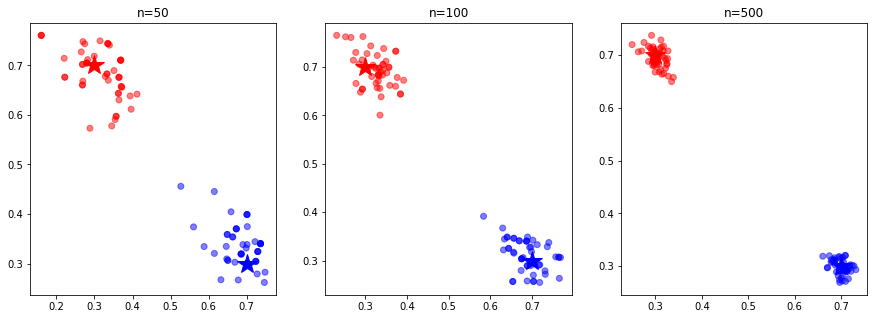

In [33]:
node_sizes = [50, 100, 500]
plt.figure(figsize = (15, 5))
for ii in range(3):
    cols = ['red' if xx == 1 else 'blue' for xx in comm_label[ii]]
    plt.subplot(1, 3, ii+1)
    cur_arr = np.array(oos_embed[ii])
    plt.scatter(cur_arr[:, 0], cur_arr[:, 1], c=cols, alpha=0.5)
    plt.plot(.3,.7,'r*', markersize=20) 
    plt.plot(.7,.3,'b*', markersize=20) 
    plt.title("n={}".format(node_sizes[ii]))

# Debugging to find correct scaling